<a href="https://colab.research.google.com/github/tyler737/EfficientNet-for-Face-Facemask-detection/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
%matplotlib inline
%pip install -U pip efficientnet==1.0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)
Requirement already up-to-date: efficientnet==1.0.0 in /usr/local/lib/python3.6/dist-packages (1.0.0)
cuda:0
Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import scipy.io as sio
import os

batch_size = 64
input_shape = (240,240)
data_dir='/content/drive/My Drive/42028-DL-CNN-2020/Assignment-3/input/car_data/car_data/'
train_dir = data_dir +'train'
test_dir = data_dir +'test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,  
    rotation_range = 5,
    horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                            class_mode="categorical", 
                                            target_size=input_shape, 
                                            batch_size=batch_size)


validation_generator=test_datagen.flow_from_directory(test_dir,
                                            class_mode="categorical", 
                                            target_size=input_shape, 
                                            batch_size=batch_size)




Found 8144 images belonging to 196 classes.
Found 8051 images belonging to 196 classes.


In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras import Model, optimizers
import efficientnet.keras as efn

base_model = efn.EfficientNetB1(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(optimizer=optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Using TensorFlow backend.


27164672/27164032 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
___________________________

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


128/128 [==============================] - 607s 5s/step - loss: 3.8294 - acc: 0.2221 - val_loss: 3.9028 - val_acc: 0.1568
Epoch 2/10
128/128 [==============================] - 135s 1s/step - loss: 1.2712 - acc: 0.6682 - val_loss: 2.4742 - val_acc: 0.4493
Epoch 3/10
128/128 [==============================] - 136s 1s/step - loss: 0.6437 - acc: 0.8265 - val_loss: 2.0312 - val_acc: 0.4848
Epoch 4/10
128/128 [==============================] - 136s 1s/step - loss: 0.3722 - acc: 0.8962 - val_loss: 1.8337 - val_acc: 0.4801
Epoch 5/10
128/128 [==============================] - 136s 1s/step - loss: 0.2693 - acc: 0.9226 - val_loss: 1.1469 - val_acc: 0.6091
Epoch 6/10
128/128 [==============================] - 135s 1s/step - loss: 0.2039 - acc: 0.9458 - val_loss: 1.7079 - val_acc: 0.6163
Epoch 7/10
128/128 [==============================] - 136s 1s/step - loss: 0.1763 - acc: 0.9488 - val_loss: 1.8475 - val_acc: 0.6284
Epoch 8/10
128/128 [==============================] - 136s 1s/step - loss: 0.150

AttributeError: ignored

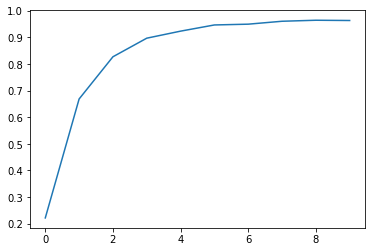

In [ ]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1 ,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=10,                           
                    workers=8,             
                    max_queue_size=32,             
                    verbose=1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

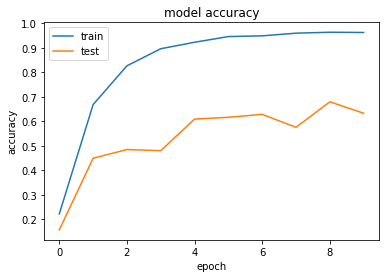

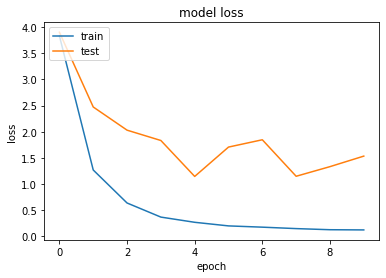

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

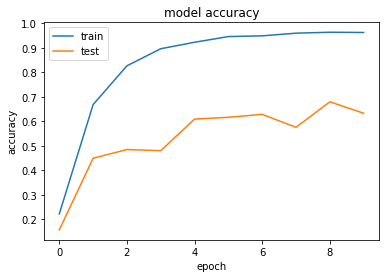

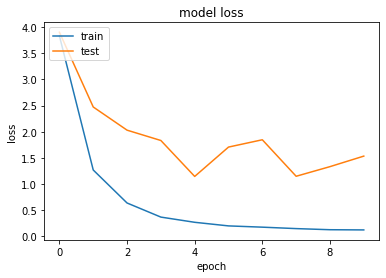

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
batch_size = 32
train_generator=train_datagen.flow_from_directory(train_dir,
                                            class_mode="categorical", 
                                            target_size=input_shape, 
                                            batch_size=batch_size)


validation_generator=test_datagen.flow_from_directory(test_dir,
                                            class_mode="categorical", 
                                            target_size=input_shape, 
                                            batch_size=batch_size)


for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Found 8144 images belonging to 196 classes.
Found 8051 images belonging to 196 classes.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____

Epoch 1/10
255/255 [==============================] - 209s 820ms/step - loss: 0.0839 - acc: 0.9781 - val_loss: 1.3993 - val_acc: 0.7564
Epoch 2/10
255/255 [==============================] - 180s 705ms/step - loss: 0.0616 - acc: 0.9848 - val_loss: 0.7503 - val_acc: 0.7590
Epoch 3/10
255/255 [==============================] - 180s 704ms/step - loss: 0.0526 - acc: 0.9878 - val_loss: 0.3215 - val_acc: 0.7703
Epoch 4/10
255/255 [==============================] - 180s 704ms/step - loss: 0.0477 - acc: 0.9887 - val_loss: 0.6028 - val_acc: 0.7705
Epoch 5/10
255/255 [==============================] - 179s 703ms/step - loss: 0.0449 - acc: 0.9898 - val_loss: 1.2260 - val_acc: 0.7728
Epoch 6/10
255/255 [==============================] - 180s 704ms/step - loss: 0.0373 - acc: 0.9913 - val_loss: 0.4114 - val_acc: 0.7763
Epoch 7/10
255/255 [==============================] - 180s 704ms/step - loss: 0.0352 - acc: 0.9926 - val_loss: 0.9002 - val_acc: 0.7752
Epoch 8/10
255/255 [============================

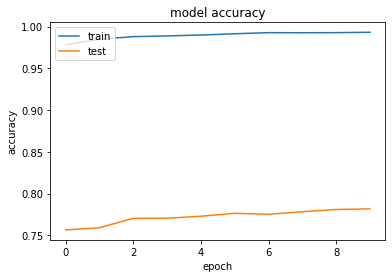

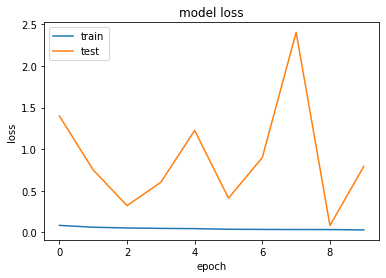

In [ ]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1 ,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=10,                           
                    workers=8,             
                    max_queue_size=32,             
                    verbose=1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')


In [ ]:
!ls saved_model/